In [1]:
## requirements
# conda install --file env/byoml_tensorflow.environment.yml
# conda activate byoml_tensorflow 
# pip install -r env/byoml_tensorflow.requirements.txt

In [2]:
MODEL_NAME='retries-example'
WINDOW=12
TEST_DATA_SIZE = 24

## Retries example based on a TensorFlow model

In this notebook we show how you can create and upload a TensorFlow model to Waylay. We will expect you to save your model using the [SavedModel format](https://www.tensorflow.org/guide/saved_model).
When a model is uploaded to Waylay, it takes a moment to compile the model. After compilation, the model will be available for use. If a request ('get' or 'predict') is done before the model is compiled, a 409 Error will be returned. Python SDK has a standard Retry policy, but this can be configured by the user as they wish. If logging is turned on, more info on each retry will be logged.

First let's import a dataset:

In [3]:
import seaborn as sns
import pandas as pd
import logging

logging.basicConfig(level=logging.ERROR)
logging.getLogger('waylay').setLevel(logging.INFO)

passengers                                                       
month        Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
year                                                                   
1949         112  118  132  129  121  135  148  148  136  119  104  118
1950         115  126  141  135  125  149  170  170  158  133  114  140
1951         145  150  178  163  172  178  199  199  184  162  146  166
1952         171  180  193  181  183  218  230  242  209  191  172  194
1953         196  196  236  235  229  243  264  272  237  211  180  201
1954         204  188  235  227  234  264  302  293  259  229  203  229
1955         242  233  267  269  270  315  364  347  312  274  237  278
1956         284  277  317  313  318  374  413  405  355  306  271  306
1957         315  301  356  348  355  422  465  467  404  347  305  336
1958         340  318  362  348  363  435  491  505  404  359  310  337
1959         360  342  406  396  420  472  548  559  463  407  362  405
1960         417  391  419  461  472  535  622  606  508  461  390  432

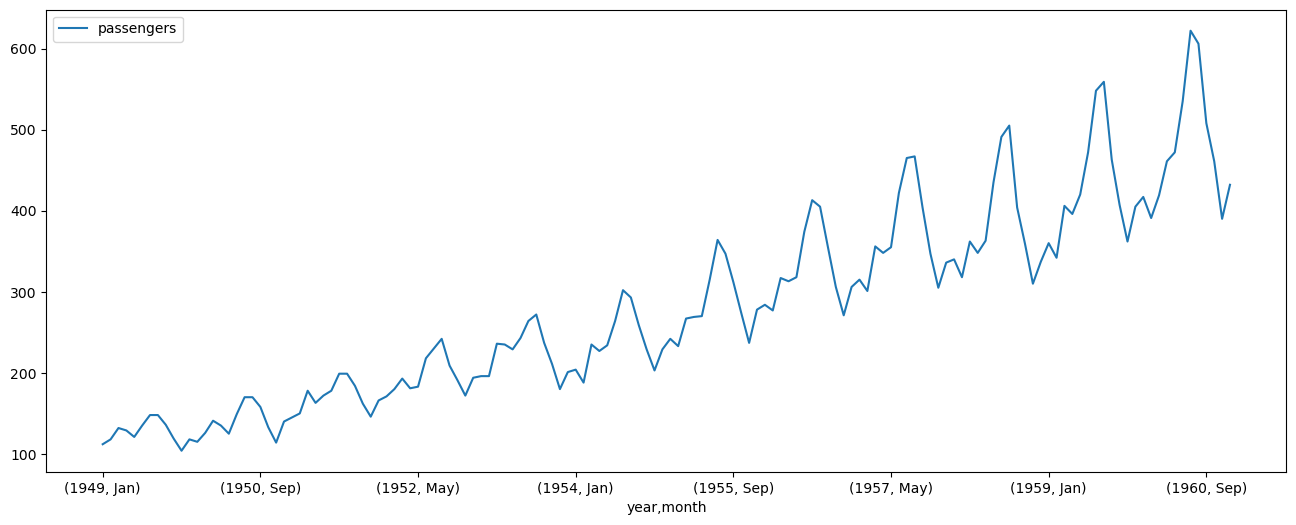

In [4]:
df = sns.load_dataset('flights')
df = df.set_index(['year', 'month'])
df.plot(figsize=(16,6))
df.unstack('month')

In [5]:
import tensorflow as tf
import numpy as np

2022-09-01 16:56:37.898298: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2022-09-01 16:56:37.898343: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2022-09-01 16:56:37.898346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [6]:


# features are a sliding window over the last 12 months, predicting the following month
def features_and_labels(input_df, window=WINDOW):
    feat_columns = [ f'+{i}M' for i in range(window) ]
    label_columns = [f'+{window}M']
    index = input_df.index[:len(input_df.index) - window]
    
    ds = tf.data.Dataset.from_tensor_slices(input_df['passengers'].values)
    feat_ds = ds.window(window, shift=1, drop_remainder=True).take(len(index))
    
    df_feat = pd.DataFrame(
        data=(list(w.as_numpy_iterator()) for w in feat_ds), 
        index=index, 
        columns=feat_columns
    )

    df_labels = pd.DataFrame(
        data=input_df.iloc[window:,0].values, 
        index=index, 
        columns=label_columns
    )
    
    return pd.concat([df_feat, df_labels], axis=1, keys=['features','labels'])

df_train = features_and_labels(df.iloc[:-TEST_DATA_SIZE])
display(df_train)
df_test = features_and_labels(df.iloc[-TEST_DATA_SIZE-WINDOW:])

2022-09-01 16:56:38.356274: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 16:56:38.356319: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-01 16:56:38.356344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (waylayadmin-NS50MU): /proc/driver/nvidia/version does not exist
2022-09-01 16:56:38.356613: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-09-01 16:56:38.381262: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2419200000 Hz
2022-09-01 16:56:38.381702: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d01e91db60 initialized for platform Host (this does not

features                                                         \
                +0M  +1M  +2M  +3M  +4M  +5M  +6M  +7M  +8M  +9M +10M +11M   
year month                                                                   
1949 Jan        112  118  132  129  121  135  148  148  136  119  104  118   
     Feb        118  132  129  121  135  148  148  136  119  104  118  115   
     Mar        132  129  121  135  148  148  136  119  104  118  115  126   
     Apr        129  121  135  148  148  136  119  104  118  115  126  141   
     May        121  135  148  148  136  119  104  118  115  126  141  135   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1957 Aug        467  404  347  305  336  340  318  362  348  363  435  491   
     Sep        404  347  305  336  340  318  362  348  363  435  491  505   
     Oct        347  305  336  340  318  362  348  363  435  491  505  404   
     Nov        305  336  340  318  362  348  363  435  491  505  404  359   
     Dec        336  340  318  362  348  363  435  491  505  404  359  310   

           labels  
             +12M  
year month         
1949 Jan      115  
     Feb      126  
     Mar      141  
     Apr      135  
     May      125  
...           ...  
1957 Aug      505  
     Sep      404  
     Oct      359  
     Nov      310  
     Dec      337  

[108 rows x 13 columns]

2022-09-01 16:56:38.529128: W tensorflow/core/framework/dataset.cc:392] Input of WindowDataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-09-01 16:56:38.530720: W tensorflow/core/framework/dataset.cc:392] Input of WindowDataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-09-01 16:56:38.532026: W tensorflow/core/framework/dataset.cc:392] Input of WindowDataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-09-01 16:56:38.533211: W tensorflow/core/framework/dataset.cc:392] Input of WindowDataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-09-01 16:56:38.534659: W tensorflow/core/framework/dataset.cc:392] Input of WindowDataset will not be optimized because

In [7]:
X_train = tf.convert_to_tensor(df_train.xs('features',axis=1).values)
y_train = tf.convert_to_tensor(df_train.xs('labels',axis=1).values)
X_test = tf.convert_to_tensor(df_test.xs('features',axis=1).values)
y_test = tf.convert_to_tensor(df_test.xs('labels',axis=1).values)

Now we can create the model, a simple one:

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],), name="previous_month"))
model.add(tf.keras.layers.Reshape((X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam' , loss='mse')

In [9]:
history = model.fit(X_train, y_train,
                    batch_size=4,
                    epochs=1000,
                    verbose=1)

Train on 108 samples
Epoch 1/1000
108/108 [==============================] - 1s 6ms/sample - loss: 74355.4931
Epoch 2/1000
108/108 [==============================] - 0s 691us/sample - loss: 72994.7771
Epoch 3/1000
108/108 [==============================] - 0s 704us/sample - loss: 71420.9706
Epoch 4/1000
108/108 [==============================] - 0s 701us/sample - loss: 69608.1136
Epoch 5/1000
108/108 [==============================] - 0s 676us/sample - loss: 67941.2655
Epoch 6/1000
108/108 [==============================] - 0s 680us/sample - loss: 66564.3571
Epoch 7/1000
108/108 [==============================] - 0s 670us/sample - loss: 65464.2722
Epoch 8/1000
108/108 [==============================] - 0s 736us/sample - loss: 64119.8516
Epoch 9/1000
108/108 [==============================] - 0s 675us/sample - loss: 62819.1703
Epoch 10/1000
108/108 [==============================] - 0s 688us/sample - loss: 61697.3882
Epoch 11/1000
108/108 [==============================] - 0s 676us/samp

Epoch 90/1000
108/108 [==============================] - 0s 754us/sample - loss: 17541.0185
Epoch 91/1000
108/108 [==============================] - 0s 731us/sample - loss: 17286.2049
Epoch 92/1000
108/108 [==============================] - 0s 686us/sample - loss: 17033.0152
Epoch 93/1000
108/108 [==============================] - 0s 675us/sample - loss: 16798.4783
Epoch 94/1000
108/108 [==============================] - 0s 700us/sample - loss: 16550.6640
Epoch 95/1000
108/108 [==============================] - 0s 750us/sample - loss: 16328.7519
Epoch 96/1000
108/108 [==============================] - 0s 696us/sample - loss: 16089.1524
Epoch 97/1000
108/108 [==============================] - 0s 669us/sample - loss: 15863.3644
Epoch 98/1000
108/108 [==============================] - 0s 708us/sample - loss: 15623.9303
Epoch 99/1000
108/108 [==============================] - 0s 760us/sample - loss: 15398.4702
Epoch 100/1000
108/108 [==============================] - 0s 731us/sample - loss

108/108 [==============================] - 0s 684us/sample - loss: 4190.3896
Epoch 179/1000
108/108 [==============================] - 0s 651us/sample - loss: 4151.2093
Epoch 180/1000
108/108 [==============================] - 0s 658us/sample - loss: 4074.7304
Epoch 181/1000
108/108 [==============================] - 0s 673us/sample - loss: 3988.8560
Epoch 182/1000
108/108 [==============================] - 0s 718us/sample - loss: 3958.4716
Epoch 183/1000
108/108 [==============================] - 0s 712us/sample - loss: 3878.5863
Epoch 184/1000
108/108 [==============================] - 0s 690us/sample - loss: 3829.3234
Epoch 185/1000
108/108 [==============================] - 0s 692us/sample - loss: 3764.5563
Epoch 186/1000
108/108 [==============================] - 0s 718us/sample - loss: 3705.1590
Epoch 187/1000
108/108 [==============================] - 0s 676us/sample - loss: 3648.8844
Epoch 188/1000
108/108 [==============================] - 0s 698us/sample - loss: 3586.2319
Epo

108/108 [==============================] - 0s 686us/sample - loss: 1354.3317
Epoch 268/1000
108/108 [==============================] - 0s 680us/sample - loss: 1341.7770
Epoch 269/1000
108/108 [==============================] - 0s 654us/sample - loss: 1350.2718
Epoch 270/1000
108/108 [==============================] - 0s 678us/sample - loss: 1318.1824
Epoch 271/1000
108/108 [==============================] - 0s 677us/sample - loss: 1365.4340
Epoch 272/1000
108/108 [==============================] - 0s 673us/sample - loss: 1326.5484
Epoch 273/1000
108/108 [==============================] - 0s 688us/sample - loss: 1268.2666
Epoch 274/1000
108/108 [==============================] - 0s 654us/sample - loss: 1241.5861
Epoch 275/1000
108/108 [==============================] - 0s 708us/sample - loss: 1238.5345
Epoch 276/1000
108/108 [==============================] - 0s 673us/sample - loss: 1228.6800
Epoch 277/1000
108/108 [==============================] - 0s 672us/sample - loss: 1209.7816
Epo

108/108 [==============================] - 0s 689us/sample - loss: 578.3660
Epoch 357/1000
108/108 [==============================] - 0s 702us/sample - loss: 594.7808
Epoch 358/1000
108/108 [==============================] - 0s 692us/sample - loss: 552.0235
Epoch 359/1000
108/108 [==============================] - 0s 706us/sample - loss: 563.0090
Epoch 360/1000
108/108 [==============================] - 0s 683us/sample - loss: 573.0036
Epoch 361/1000
108/108 [==============================] - 0s 705us/sample - loss: 557.3822
Epoch 362/1000
108/108 [==============================] - 0s 690us/sample - loss: 568.3522
Epoch 363/1000
108/108 [==============================] - 0s 687us/sample - loss: 543.9248
Epoch 364/1000
108/108 [==============================] - 0s 707us/sample - loss: 530.0872
Epoch 365/1000
108/108 [==============================] - 0s 720us/sample - loss: 563.9299
Epoch 366/1000
108/108 [==============================] - 0s 705us/sample - loss: 645.0731
Epoch 367/1000

108/108 [==============================] - 0s 672us/sample - loss: 341.2980
Epoch 447/1000
108/108 [==============================] - 0s 681us/sample - loss: 278.5525
Epoch 448/1000
108/108 [==============================] - 0s 672us/sample - loss: 280.7582
Epoch 449/1000
108/108 [==============================] - 0s 670us/sample - loss: 299.1658
Epoch 450/1000
108/108 [==============================] - 0s 676us/sample - loss: 270.0733
Epoch 451/1000
108/108 [==============================] - 0s 674us/sample - loss: 370.0497
Epoch 452/1000
108/108 [==============================] - 0s 675us/sample - loss: 290.0190
Epoch 453/1000
108/108 [==============================] - 0s 673us/sample - loss: 276.3333
Epoch 454/1000
108/108 [==============================] - 0s 666us/sample - loss: 293.2353
Epoch 455/1000
108/108 [==============================] - 0s 661us/sample - loss: 273.5414
Epoch 456/1000
108/108 [==============================] - 0s 677us/sample - loss: 287.7489
Epoch 457/1000

108/108 [==============================] - 0s 698us/sample - loss: 243.9625
Epoch 537/1000
108/108 [==============================] - 0s 701us/sample - loss: 200.2065
Epoch 538/1000
108/108 [==============================] - 0s 711us/sample - loss: 175.7091
Epoch 539/1000
108/108 [==============================] - 0s 696us/sample - loss: 174.7778
Epoch 540/1000
108/108 [==============================] - 0s 696us/sample - loss: 179.5338
Epoch 541/1000
108/108 [==============================] - 0s 682us/sample - loss: 172.2788
Epoch 542/1000
108/108 [==============================] - 0s 703us/sample - loss: 160.2933
Epoch 543/1000
108/108 [==============================] - 0s 684us/sample - loss: 161.0381
Epoch 544/1000
108/108 [==============================] - 0s 695us/sample - loss: 152.8466
Epoch 545/1000
108/108 [==============================] - 0s 694us/sample - loss: 152.9143
Epoch 546/1000
108/108 [==============================] - 0s 704us/sample - loss: 189.6126
Epoch 547/1000

108/108 [==============================] - 0s 682us/sample - loss: 260.2709
Epoch 627/1000
108/108 [==============================] - 0s 704us/sample - loss: 176.2758
Epoch 628/1000
108/108 [==============================] - 0s 674us/sample - loss: 163.1246
Epoch 629/1000
108/108 [==============================] - 0s 704us/sample - loss: 113.6715
Epoch 630/1000
108/108 [==============================] - 0s 682us/sample - loss: 101.5838
Epoch 631/1000
108/108 [==============================] - 0s 691us/sample - loss: 103.4502
Epoch 632/1000
108/108 [==============================] - 0s 702us/sample - loss: 153.8944
Epoch 633/1000
108/108 [==============================] - 0s 684us/sample - loss: 119.1443
Epoch 634/1000
108/108 [==============================] - 0s 685us/sample - loss: 134.0615
Epoch 635/1000
108/108 [==============================] - 0s 696us/sample - loss: 213.1322
Epoch 636/1000
108/108 [==============================] - 0s 686us/sample - loss: 164.5355
Epoch 637/1000

108/108 [==============================] - 0s 882us/sample - loss: 93.6146
Epoch 717/1000
108/108 [==============================] - 0s 872us/sample - loss: 81.3619
Epoch 718/1000
108/108 [==============================] - 0s 880us/sample - loss: 61.1240
Epoch 719/1000
108/108 [==============================] - 0s 870us/sample - loss: 67.6196
Epoch 720/1000
108/108 [==============================] - 0s 883us/sample - loss: 63.2835
Epoch 721/1000
108/108 [==============================] - 0s 878us/sample - loss: 60.6428
Epoch 722/1000
108/108 [==============================] - 0s 883us/sample - loss: 61.9426
Epoch 723/1000
108/108 [==============================] - 0s 850us/sample - loss: 63.8158
Epoch 724/1000
108/108 [==============================] - 0s 880us/sample - loss: 78.0197
Epoch 725/1000
108/108 [==============================] - 0s 861us/sample - loss: 60.8010
Epoch 726/1000
108/108 [==============================] - 0s 892us/sample - loss: 64.6098
Epoch 727/1000
108/108 [=

Epoch 807/1000
108/108 [==============================] - 0s 856us/sample - loss: 61.3326
Epoch 808/1000
108/108 [==============================] - 0s 892us/sample - loss: 62.2536
Epoch 809/1000
108/108 [==============================] - 0s 865us/sample - loss: 50.1088
Epoch 810/1000
108/108 [==============================] - 0s 855us/sample - loss: 44.9013
Epoch 811/1000
108/108 [==============================] - 0s 870us/sample - loss: 72.6584
Epoch 812/1000
108/108 [==============================] - 0s 844us/sample - loss: 64.6805
Epoch 813/1000
108/108 [==============================] - 0s 859us/sample - loss: 61.0921
Epoch 814/1000
108/108 [==============================] - 0s 881us/sample - loss: 59.9726
Epoch 815/1000
108/108 [==============================] - 0s 835us/sample - loss: 67.5853
Epoch 816/1000
108/108 [==============================] - 0s 863us/sample - loss: 102.3351
Epoch 817/1000
108/108 [==============================] - 0s 851us/sample - loss: 73.8894
Epoch 818

Epoch 898/1000
108/108 [==============================] - 0s 843us/sample - loss: 61.5502
Epoch 899/1000
108/108 [==============================] - 0s 850us/sample - loss: 42.6531
Epoch 900/1000
108/108 [==============================] - 0s 850us/sample - loss: 56.1264
Epoch 901/1000
108/108 [==============================] - 0s 840us/sample - loss: 52.4297
Epoch 902/1000
108/108 [==============================] - 0s 860us/sample - loss: 33.0716
Epoch 903/1000
108/108 [==============================] - 0s 815us/sample - loss: 42.3994
Epoch 904/1000
108/108 [==============================] - 0s 839us/sample - loss: 85.8009
Epoch 905/1000
108/108 [==============================] - 0s 840us/sample - loss: 105.3095
Epoch 906/1000
108/108 [==============================] - 0s 816us/sample - loss: 135.8530
Epoch 907/1000
108/108 [==============================] - 0s 842us/sample - loss: 252.6724
Epoch 908/1000
108/108 [==============================] - 0s 826us/sample - loss: 339.5301
Epoch 

108/108 [==============================] - 0s 851us/sample - loss: 32.2905
Epoch 989/1000
108/108 [==============================] - 0s 871us/sample - loss: 55.7597
Epoch 990/1000
108/108 [==============================] - 0s 878us/sample - loss: 59.3319
Epoch 991/1000
108/108 [==============================] - 0s 833us/sample - loss: 54.7432
Epoch 992/1000
108/108 [==============================] - 0s 861us/sample - loss: 59.2160
Epoch 993/1000
108/108 [==============================] - 0s 845us/sample - loss: 100.1928
Epoch 994/1000
108/108 [==============================] - 0s 835us/sample - loss: 83.0869
Epoch 995/1000
108/108 [==============================] - 0s 831us/sample - loss: 60.1648
Epoch 996/1000
108/108 [==============================] - 0s 849us/sample - loss: 87.4216
Epoch 997/1000
108/108 [==============================] - 0s 837us/sample - loss: 206.3680
Epoch 998/1000
108/108 [==============================] - 0s 837us/sample - loss: 162.0675
Epoch 999/1000
108/108

Let's validate if the model learned something:

<AxesSubplot:xlabel='year,month'>

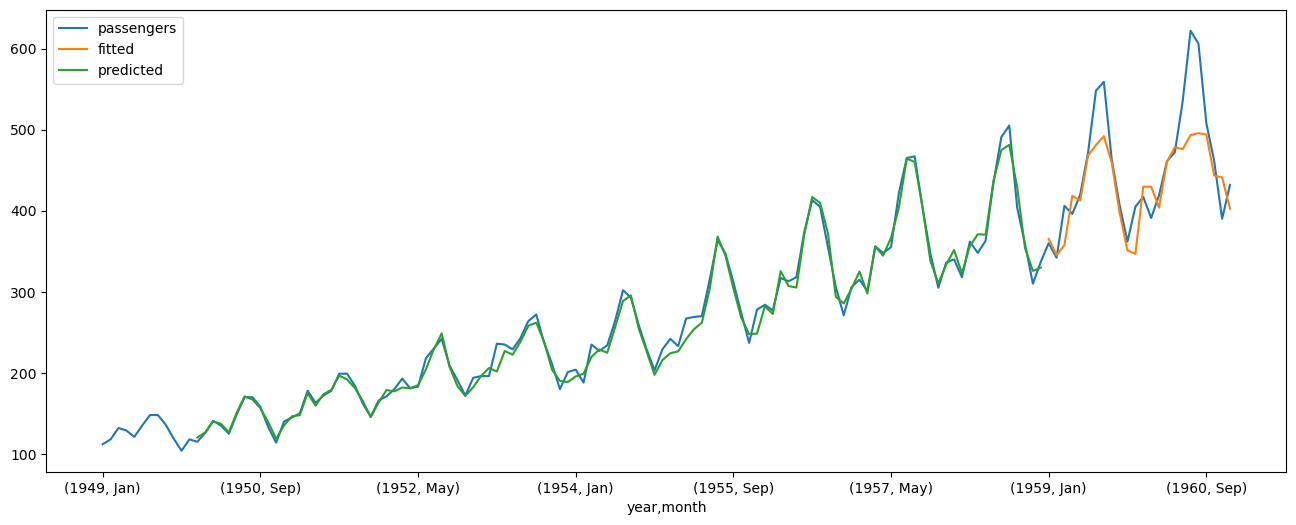

In [10]:
df_pred = df.copy()
df_pred['fitted'] = np.NaN
df_pred['predicted'] = np.NaN
df_pred.iloc[-TEST_DATA_SIZE:,1] = model.predict(X_test)
df_pred.iloc[WINDOW:-TEST_DATA_SIZE,2] =  model.predict(X_train)

df_pred.plot(figsize=(16,6))

## Save the model and upload 

We will save the model in SavedModel format and then upload it to Waylay. 

In [11]:
from waylay import WaylayClient, RestResponseError
import tempfile

waylay = WaylayClient.from_profile()

In [12]:
waylay.config

<WaylayConfig({"credentials": {"type": "client_credentials", "api_key": "429a6f89775dbc0a04d215d5", "api_secret": "********", "gateway_url": "https://api-io.waylay.io", "accounts_url": null}, "profile": "_default_", "settings": {}})>

There are many other ways to create a SavedModel, for example using [Estimators](https://www.tensorflow.org/guide/estimator#savedmodels_from_estimators) or using a custom [Module](https://www.tensorflow.org/guide/saved_model#saving_a_custom_model), all follow the same flow to upload the model to Waylay. Just pass the directory where you saved your model to the SDK and we will do the rest.

In [13]:
# clean up existing model
import time
try:
    waylay.byoml.model.remove(MODEL_NAME)
    display(f'Removed: {MODEL_NAME}')
except RestResponseError as e:
    display(f'Ignored: {e}')

INFO:waylay.service.byoml.model.server-timing:no-server-timing-available;dur=0.000


"Ignored: ByomlActionError(503: 'operation=server_error'; DELETE 'https://api-io.waylay.io/ml/v1/models/retries-example')"

In [14]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example'
)

result

2022-09-01 16:58:32.476237: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=200;dur=4116.261


{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

After upload, it can take a few seconds before the model is available for execution.

This can be seen when by inspecting the `ready` property when retrieving the model.

In [15]:
try:
    result = waylay.byoml.model.get(MODEL_NAME)
    display(result)
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=GET;status_code=200;dur=2155.326


{'createdBy': 'users/d39dcd31-c837-42b9-9952-cff52d76e04a',
 'createdOn': '2022-09-01T14:58:34.528000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/d39dcd31-c837-42b9-9952-cff52d76e04a',
 'updatedOn': '2022-09-01T14:58:37.637000+00:00',
 'version': '1'}

For resources such as a BYOML model, you can poll until the deployment is ready by including the `retry_until_ready` flag.

In [16]:
try:
    result = waylay.byoml.model.get(MODEL_NAME, retry_until_ready=True)
    display(result)
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=GET;status_code=200;dur=2018.913
INFO:waylay.byoml.model.get:Retrying byoml.model.get in 4.0 seconds as it raised Model is not ready yet..
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=GET;status_code=200;dur=2023.200
INFO:waylay.byoml.model.get:Retrying byoml.model.get in 4.0 seconds as it raised Model is not ready yet..
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=GET;status_code=200;dur=2021.624
INFO:waylay.byoml.model.get:Retrying byoml.model.get in 4.0 seconds as it raised Model is not ready yet..
INFO:waylay.service.byoml.model.se

{'createdBy': 'users/d39dcd31-c837-42b9-9952-cff52d76e04a',
 'createdOn': '2022-09-01T14:58:34.528000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'ready': True,
 'supported_endpoints': ['predict'],
 'updatedBy': 'users/d39dcd31-c837-42b9-9952-cff52d76e04a',
 'updatedOn': '2022-09-01T14:58:37.637000+00:00',
 'version': '1'}

When making predictions, retry handling will also wait until the model is ready:

In [17]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
    display(predictions[:3])
except Exception as e:
    display(e)
    

INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=200;dur=1662.674
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=200;dur=1678.656


[[365.293182], [345.039764], [357.677826]]

You can provide additional parameters to influence the retry behaviour:
* `retry_attempts=20`   : Maximal number of retries.
* `retry_max_delay=120` : Maximal delay in seconds.
* `timeout`             : Maximal number of seconds that the client will wait for one attempt. This parameter is available on most Python SDK calls.

In [18]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), retry_attempts=1, retry_max_delay=1)
    display(predictions[:3])
except Exception as e:
    display(e)
    

INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=200;dur=12.013
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=200;dur=26.135


[[365.293182], [345.039764], [357.677826]]

In [19]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
except Exception as e:
    display(f'{e}')

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=DELETE;status_code=200;dur=126.978


Retry behaviour won't be triggered by non-existing resources, but only on responses with specific HTTP status codes (`409`, `429`, `500`, `502`, `503`, `504`, `508`). The _NOT FOUND_ `404` error will just be forwarded to the user:


In [20]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
    display(predictions[:3])
except Exception as e:
    display(e)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=404;dur=14.611


waylay.service.byoml._exceptions.ByomlActionError('operation=not_found_error')

In [21]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example',
    timeout=300
)

result

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=409;dur=219.238
INFO:waylay.byoml.model._create:Retrying byoml.model._create in 4.0 seconds as it raised ByomlActionError(409: 'A plug with this name and version has not been completely removed yet. Please retry later.'; POST 'https://api-io.waylay.io/ml/v1/models').
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=409;dur=192.401
INFO:waylay.byoml.model._create:Retrying byoml.model._create in 4.0 seconds as it raised ByomlActionError(409: 'A plug with this name and version has not been completely removed yet. Please retry later.'; POST 'https://api-io.waylay.io/ml/v1/models').
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models;environmen

{'createdOn': '2021-01-04T00:00:00+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.4',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'tensorflow example'},
 'name': 'retries-example',
 'updatedOn': '2021-01-04T00:00:00+00:00',
 'version': '1'}

We immediately try prediction on the new model with a low `timeout=5` and `retry_attempts = 1`: this should fail as the endpoint will not be ready.

In [22]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), timeout=5, retry_attempts = 1)
    display(predictions[:3])
except Exception as e:
    display(e)
    


ERROR:simple_rest_client.decorators:The read operation timed out
Traceback (most recent call last):
  File "/home/waylay-admin/miniconda3/envs/byoml_tensorflow/lib/python3.7/site-packages/httpcore/_exceptions.py", line 8, in map_exceptions
    yield
  File "/home/waylay-admin/miniconda3/envs/byoml_tensorflow/lib/python3.7/site-packages/httpcore/backends/sync.py", line 26, in read
    return self._sock.recv(max_bytes)
  File "/home/waylay-admin/miniconda3/envs/byoml_tensorflow/lib/python3.7/ssl.py", line 1056, in recv
    return self.read(buflen)
  File "/home/waylay-admin/miniconda3/envs/byoml_tensorflow/lib/python3.7/ssl.py", line 931, in read
    return self._sslobj.read(len)
socket.timeout: The read operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/waylay-admin/miniconda3/envs/byoml_tensorflow/lib/python3.7/site-packages/httpx/_transports/default.py", line 60, in map_httpcore_exceptions
    yiel

waylay.exceptions.RestConnectionError(simple_rest_client.exceptions.ClientConnectionError(httpx.ReadTimeout('The read operation timed out')))

Calling without extra parameters should normally wait/retry long enough for succesfull results.

In [23]:
predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
display(predictions[:3])

INFO:waylay.service.byoml.model.server-timing:no-server-timing-available;dur=0.030
INFO:waylay.byoml.model.predict:Retrying byoml.model.predict in 4.0 seconds as it raised ByomlActionError(502: 'operation=server_error'; POST 'https://api-io.waylay.io/ml/v1/models/retries-example/predict').
INFO:waylay.service.byoml.model.server-timing:billing/byoml.predict;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=200;dur=26805.318
INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>/predict;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=POST;status_code=200;dur=26992.919


[[365.293182], [345.039764], [357.677826]]

In [24]:
waylay.byoml.model.remove(MODEL_NAME)

INFO:waylay.service.byoml.model.server-timing:monitor/byoml./models/<name>;environment=production;tenant=2b14dbfc-81ac-46b9-8dc4-887fabca1d1f;domain=trustworthy-duck.waylay.io;method=DELETE;status_code=200;dur=291.711


{'message': 'Model retries-example: all versions deleted',
 'name': 'retries-example',
 'versions': ['0.0.1']}